# Exponentielle Regression in Octave

### von Anna Hundertmark (Universität Koblenz-Landau) und Ingo Dahn

# Daten

Wir suchen eine Exponentialfunktion zur Beschreibung der Ausbreitung der COVID-19-Pandemie in Deutschland bis Ende März 2020. Dazu analysieren wir die vom Robert-Koch-Institut (RKI) vom Tag 0 (24.2.2020), dem Tag des ersten Statusreports des RKI, bis zum Tag 37 (1.4.2020) gemeldeten Infektionszahlen.

Notiz zur Octave-Syntax: steht % in einer Zeile, ist der Text danach als Kommentar zu verstehen (er wird nicht ausgeführt),
steht ; am Ende einer Zeile, wird die Ausgabe der Variablen im Output unterdrückt.

Diese Seite wird unter der [Creative Commons Lizenz CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) veröffentlicht.

In [1]:
%Daten RKI
   timesWHO=[0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36 37];
    inf_falleWHO=[16 18 21 26 53 66 117 150 188 240 400 639 795 902 1139 1296 1567 2369 3062 3795 4838 6012 7156 8198 10999 13957 16662 18610 22672 27436 31554 36508 42288 48582 52547 57298 61913 67366];
    %%aktuelle Daten: (passen nicht mehr zur exponentieller Funktion)
    %% A=coronaData();
    %% inf_falleWHO=A(1,:);
     n=length(inf_falleWHO);


## Exponentielles Wachstum

Zunächst werden die Infektionszahlen grafisch dargestellt.

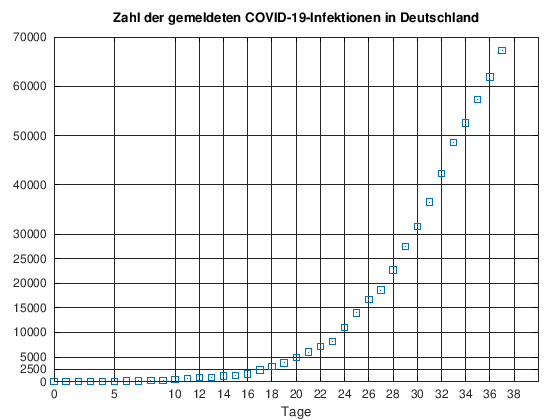

In [2]:
% figure(1)
    plot ( timesWHO,inf_falleWHO, 's', "linewidth",2 )
    h=get(gcf, "currentaxes");
    set(h, "fontsize", 12, "linewidth", 2);
    set(gca,'xtick',[0,5,10,12,14,16,18,20, 22, 24,26,28,30,32, 34,36,38])
    set(gca,'ytick',[0, 2500,5000,10000,15000,20000,25000 30000 40000 50000 60000 70000 80000 90000 100000])
    grid on
    title ('Zahl der gemeldeten COVID-19-Infektionen in Deutschland')
    xlabel ('Tage')
    hold off

## Exponentielle Regression

Eine Exponentialfunktion wird durch 
$$y(t)=ae^{k.t}$$ 
definiert, wobei $a=y(0)$ der Anfangswert bei $t=0$ und $k$ die Wachstumsrate, in unserem Fall die Populationwachstumsrate bzw. die Infektionsrate, ist. Das  mathematische Modell des in dieser frühen Phase der Pandemie unbeschränkten Wachstums ist die gewöhnliche Differentialgleichung $y'(t)=ky(t)$.
Die konstante (tägliche) Infektionsrate $k\in [0,1]$ beschreibt den Anteil der Infizierten, der von der bereits infizierter Population   täglich neu  infiziert werden.

Die Parameter $a,\, k$ werden zuerst geschätzt, hier wird $a=300,\, k=0.16$ angenommen.

**Aufgabe:** Wenn Sie das Prinzip der Regression verstanden haben, so experimentieren Sie mit anderen Werten.
* Wählen Sie für diese Startwerte $a$ bzw. $k$ große bzw. kleine Werte.
* Wie ändert sich dadurch das Ergebnis?
* Wie ändert sich dadurch die Zeit, die für die Berechnung benötigt wird?

In [3]:
%Daten RKI
       %initial value guess
     a=70
     %approximate growth rate,(estimated)
     k=0.16
     expon=@(t,k,a) a*exp(k.*t)

a =  70


k =  0.16000


expon =

@(t, k, a) a * exp (k .* t)



Nun werden die geschätzten Parameter $a,k$ so variiert, dass der Fehler der Exponentialkurve zu den Daten $d_n,\ n=1,2,\ldots N$ möglichst klein. Dabei ist es sehr wichtig das Verhalten dieses Fehlers als Funktion von  $a,k$ zu  beachten, um ein lokales Minimum des Fehlers zu erreichen. (Steigt der Fehler je weiter man sich von $a$ oder $k$ entfernt, hat man lokales Minimum erreicht, sinkt der Fehler in einer Richtung, muss man die Schätzungsgsparameter  $a,k$ in diese Richtung verschieben oder eine größere Umgebung für  $a,k$ betrachten.)

### Die Methode der kleinsten Quadrate

Bezeichne man die Probeparameter   als $a_j$, $a_j=a+ja,\ j=-1, -0.9,-0.8, \ldots 20 $ und $k_i=k+ik,\ i=-1, -0.99,-0.98, \ldots 1$.
Im folgendem Code sind die Probeparameter so gewählt, dass Sie in einer Umgebung der geschätzten Parameter $a,k$ liegen.

Es wird ein globales Fehlermaß, das sog. Residuum,  als die Summe der Quadrate der Abstände  der Daten $d_n$ von den Kurvenpunkten $y(t_n)=a e^{k.t_n}$ für diese Probeparameter berechnet:
$$R(a_j,k_i)=\sum_{n=1}^N (a_j e^{k_i.t_n}-d_n)^2=\|a_j e^{k_i.\vec{t}}-\vec{d}\|^2_2, \ \vec{t}=(t_1,\ldots t_n), \ \vec{d}=(d_1,\ldots d_n). $$
(Dies kann in Octave mithilfe der Euklidichen Norm des Unterschiedes zweier Vektoren elegant berechnet werden)

Im folgenden  Code wird zuerst  das Minimum des Residuums $R(a_j,k_i)$  bezüglich $k_i$  für jedes feste $a_j$ (mithilfe einer 'for' -Schleife für $i$)  gesucht,
es wird also ein $k_{opt}^j$ für jedes $j$ gefunden mit $$R(a_j,k_{opt}^j) \equiv \min_{\forall i}R(a_j,k_i).$$

Danach wird nach dem Prinzip: ''Talwanderung bis zum tiefsten Punkt'' noch ein Minimum für $R(a_j,k_{opt}^j) $   bezüglich $j$ gesucht (mithilfe einer zweiten 'for'-Schleife für $j$). Dadurch wird also ein bestimmter Index $I$ gefunden  für welchen das Residuum minimal ist:
$$\min_{\forall j} \Big\{\min_{\forall i } R( a_j,k_i)\Big\} \equiv  \min_{\forall j}R(a_j,k_{opt}^j)\equiv R(a_{I},k_{opt}^I).$$
 
Den Anfangswert mit diesem Index  bezeichen wir als optimales $a$, $a_{opt}:=a_I$ und die entsprechend zu diesem Anfangswert zugehörige optimale Wachstumsrate $k_{opt}^I$ bezeichnen wir auch mit   $k_{opt}:=k_{opt}^I$. Die entsprechende  Variablen  im Code heißen  $k_{opt}:=$ `Optim_Wachsrate` und  $a_{opt}:=$ `Optim_Anfangswert`, und werden im  folgendem Schritt ausgegeben.



Zum Schluß werden die optimale Wachstumsrate $k_{opt}$, der optimaler Anfangswert $a_{opt}$, der Fehler (das Residuum)  und eine Graphik der Exponentialregression zu den RKI- Daten ausgegeben.

Optim_Wachsrate =  0.13600


Optim_Anfangswert =  483


Optim_Residuum =  15287.50401


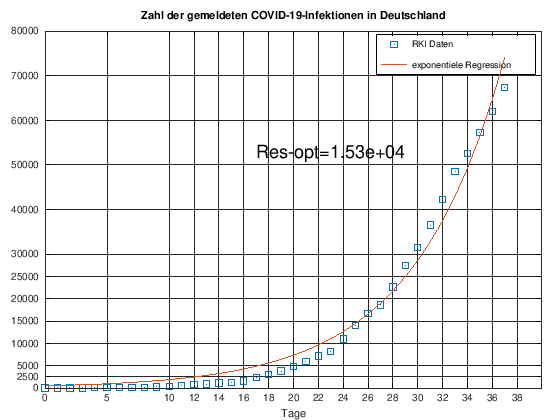

In [4]:
%regression for growth rate k and initial value a: 
     kopt=0;
     res_vector=0;
     a_vector=0;
     MaxN=100;
     for j=-MaxN/10:2*MaxN
       aj=a+j*a*10/MaxN;
     for i=-MaxN:MaxN
       ki=k+i*k/MaxN;

       res(i+MaxN+1)=norm ((expon(timesWHO,ki,aj)-inf_falleWHO),2);

       if res(i+MaxN+1)==min(res)
         Ind=i;
         kopt= [kopt ki];
         res_vector=[res_vector min(res)];
         a_vector=[a_vector aj];

        endif
     endfor
     resMatrix(j+MaxN/10+1,:)= res;
     endfor
     for i=2:length(res_vector)
      if res_vector(i)==min(res_vector(2:length(res_vector)))
        Ind2=i;
       endif
       endfor
     koptvec=kopt;
     kopt=kopt(Ind2);
     res_vector(Ind2);
     a_vector(Ind2);
     %optimal growth rate, initial value a, minimal residue
     Optim_Wachsrate=kopt
     Optim_Anfangswert=a_vector(Ind2)
     Optim_Residuum=res_vector(Ind2)
     plot ( timesWHO,inf_falleWHO, 's', "linewidth",2 )
     hold on
     plot ( timesWHO, expon(timesWHO, kopt,Optim_Anfangswert), '-',"linewidth",3 );
     set(gca,'xtick',[0,5,10,12,14,16,18,20, 22, 24,26,28,30,32, 34,36,38])
     set(gca,'ytick',[0, 2500,5000,10000,15000,20000,25000 30000 40000 50000 60000 70000 80000 90000 100000])
     grid on
    resi= res_vector(Ind2);
    text (17,53000, ['Res-opt=' num2str(resi,3)], "fontsize", 18)
    xlabel('Tage')
    legend ("RKI Daten", "exponentiele Regression")
    title ('Zahl der gemeldeten COVID-19-Infektionen in Deutschland')
   

# Residuum
 
In den folgenden Graphen wird das Verhalten  der Residuumfunktion  bezüglich $k$ bzw. $a$ abgebildet:

Der erste Graph zeigt das Residuum als Funktion von $k$ für den optimalen Anfangswert  $a_{opt}$, d.h. $R(a_{opt}; k_{i})$ für alle $i$.

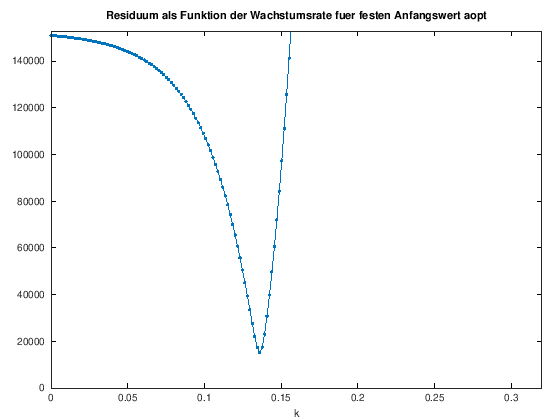

In [5]:
kvec=k+(-MaxN:MaxN)*k/MaxN;
     for i=1:length(kvec)
      resvec(i)=norm ((expon(timesWHO,kvec(i),Optim_Anfangswert)-inf_falleWHO),2);
     endfor

    figure(2)
    hold off
     plot(kvec, resvec, '.-')
      
      h=get(gcf, "currentaxes");
     set(h, "fontsize", 10, "linewidth", 2);
      xlabel('k')
      title ('Residuum als Funktion der Wachstumsrate fuer festen Anfangswert aopt')
     %optional
      axis([0 2*k 0 10*Optim_Residuum])

Der folgende Graph zeigt das Residuum bei optimaler Infektionsrate $k_{opt}$  und  für  benachbarte Werte $0.95k_{opt},\  1.1 k_{opt} $ als Funktion des Anfangswertes $a_j$, d. h. $R(a_j; k_{opt}),\ R(a_j; 0.95k_{opt}),R(a_j; 1.1k_{opt})$ für alle $j$.  Zusätzlich wird  hier zum Vergleich die Kurve der bezüglich $k$ minimalen   Residuen  , $\min_{_\forall k_i}R(a_j;k_i)=R(a_j, k_{opt}^j)$ für jeden  der untersuchten Anfansgwerte  $a_j$ abgebildet.

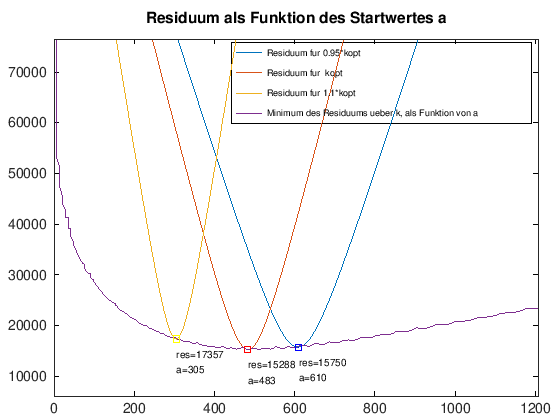

In [6]:
avec=a+(-MaxN/10:2*MaxN)*a*10/MaxN;
     for i=1:length(avec)
      resvec2(i)=norm ((expon(timesWHO,Optim_Wachsrate,avec(i))-inf_falleWHO),2);
      resvec1(i)=norm ((expon(timesWHO,0.95*Optim_Wachsrate,avec(i))-inf_falleWHO),2);
      resvec3(i)=norm ((expon(timesWHO,1.1*Optim_Wachsrate,avec(i))-inf_falleWHO),2);
      endfor
%------------------------------------------------------------------------------------
% x-Position für Residuumausgabe und Markierugen an den Kurven für benachbarte Wachstumsrate: (anpassen)
%------------------------------------------------------------------------------------
        a1=610;
        a3=305;
%---------------------------------------------------------------------
          resid1=norm ((expon(timesWHO,0.95*Optim_Wachsrate,a1)-inf_falleWHO),2);
          resid2=norm ((expon(timesWHO,Optim_Wachsrate,Optim_Anfangswert)-inf_falleWHO),2);
          resid3=norm ((expon(timesWHO,1.1*Optim_Wachsrate,a3)-inf_falleWHO),2);
    % figure (3)
      hold off
      plot(avec, resvec1,avec, resvec2,avec, resvec3)
      hold on
      plot(a_vector, res_vector, '-')

       text(a1,resid1-0.2*Optim_Residuum,['res=' num2str(resid1, 5)]);
          text(a1,resid1-0.4*Optim_Residuum, ['a='  num2str(a1)]);
          plot (a1,resid1,'sb', 'linewidth', 3)

          text(Optim_Anfangswert,resid2-0.2*Optim_Residuum,['res=' num2str(resid2,5)]);
          text(Optim_Anfangswert, resid2-0.4*Optim_Residuum, ['a=' num2str(Optim_Anfangswert)]);
           plot (Optim_Anfangswert,resid2,'sr', 'linewidth', 3)

          text(a3,resid3-0.2*Optim_Residuum, ['res=' num2str(resid3,5)] )
          text(a3, resid3-0.4*Optim_Residuum, ['a='  num2str(a3)]);
           plot (a3,resid3,'sy', 'linewidth', 3)
%-------------------------- neu ------------------------------------

      title ('Residuum als Funktion des Startwertes a')
      legend ('Residuum fur 0.95*kopt','Residuum fur  kopt', 'Residuum fur 1.1*kopt',"Minimum des Residuums ueber k, als Funktion von a")
      h=get(gcf, "currentaxes");
      set(h, "fontsize", 14, "linewidth", 2);
      axis([0 2.5*Optim_Anfangswert  0.4*Optim_Residuum 5*Optim_Residuum])

Mit Blick auf dieses Diagramm kann man unser Regressionsverfahren auch so erläutern (**Aufgabe:** Vollziehen Sie die Schritte anhande des Codes zur Berechnung der exponentiellen Regression nach.):

Für jeden Wert für $a$ auf der Abszisse, etwa $a=610$ variieren wir $k$. Dabei befindet sich der Wert des Residuums für $a=610$ auf der blauen Kurve und erreicht seinen kleinsten Wert im blauen Punkt mit einem Wert von ungefähr 16180. Wir merken uns das zugehörige $k$, bei dem dieser minimale Wert für das gegebene $a$ erreicht wurde.

Dies wiederholen wir für alle Werte $a$. Die so ermittelten minimalen Residuen liegen dann auf der unteren Kurve. Deren kleinster Wert wird im roten Punkt erreicht. Er ist ein globales Minimum der Residuumsfunktion in Abhängigkeit von $a$ und $k$ (s. nächstes Diagramm).
$a=510$ und der zugehörige Wert für $k$ definieren dann die gesuchte Regressionsfunktion.

**Aufgaben:** Wovon hängt die Anzahl der Schritte ab, die der Algorithmus zur Bestimmung des minimalen Residuums benötigt? Finden Sie einen schnelleren Algorithmus? Unter welchen Voraussetzungen?

## Residuum als Funktion von a und k:  $R:{\mathbb R}^2\to \mathbb R$ 

Um einen anderen Blickwinkel zu wählen, ändert man die Koordinaten in 'view(-30,20)'. Die Achesaussschnitte kann man in 'axis ( [xmin xmax ymin ymax zmin zmax])' ändern. **Experimentieren Sie!**

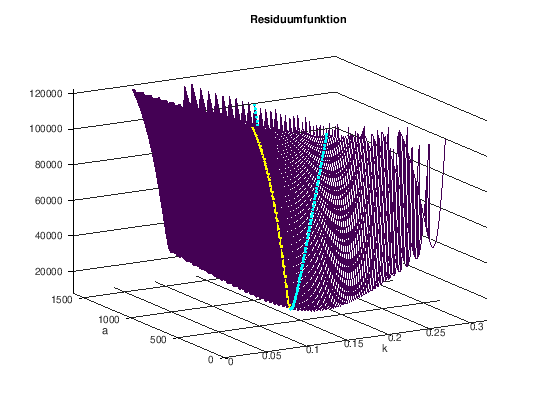

In [7]:
    % figure(4) 
    hold off
     meshc( k+(-MaxN:1*MaxN)*k/MaxN, a+(-MaxN/10:2*MaxN)*a*10/MaxN,resMatrix)
     hold on
     title ('Residuumfunktion')
     view(-30,20)
     plot3(kvec, Optim_Anfangswert*ones(1,length(kvec)),resvec, '-y', 'linewidth', 8)
     plot3( Optim_Wachsrate*ones(1,length(avec)),avec, resvec2, '.c', 'linewidth', 8)
     xlabel('       k  ')
     ylabel('   a        ')

     grid on
     hold off
     %optional
    axis([0.0 k*2 0 a*23  0.5*Optim_Residuum 8*Optim_Residuum])

Die gelbe Kurve zeigt, wo für gegebenes $a$ die optimalen $k$ liegen, für die das Residuum minimal wird.

**Aufgabe:** Überlegen Sie, wie eine Murmel auf der Fläche zu einem Minimum rollen würde und vergleichen Sie dies mit dem hier beschriebenen Verfahren.